

# Requirments

In [ ]:
!pip install python-metar
!pip install metar

  Preparing metadata (setup.py) ... done
  Created wheel for python-metar: filename=python_metar-1.4.0-py3-none-any.whl size=16926 sha256=3bd1a4d0829b779e6b9965ab6583596a048375d8cfd9ebe94e259297caf0b266
  Stored in directory: /root/.cache/pip/wheels/f3/2e/3f/04a760eb9978f1571178d51ca1c00ca334854fd50febb65e6d
Successfully built python-metar
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 3.2 MB/s eta 0:00:00


In [ ]:
  import requests
  import json
  from datetime import datetime
  from metar.Metar import Metar
  import pandas as pd
  import folium
  import json
  import math
  from geopy.distance import geodesic
  import re
  from datetime import datetime
  from google.colab import files


# Data Fetched


In [ ]:

FLIGHT_PATH = ""

class WeatherDataManager:
    def __init__(self):
        self.weather_data = {}
        self.urls = {
            "PIREP": "https://aviationweather.gov/api/data/pirep",
            "AIRSIGMET": "https://aviationweather.gov/api/data/airsigmet",
            "METAR": "https://aviationweather.gov/api/data/metar",
            "TAF": "https://aviationweather.gov/api/data/taf"
        }

    def fetch_aviation_data(self, data_type, icao, additional_params=None):
        url = self.urls.get(data_type)
        if not url:
            return [f"Invalid data type: {data_type}"]
        params = {"format": "json"}
        if data_type == "PIREP":
            params.update({"region": icao, "num": 5})
        elif data_type == "AIRSIGMET":
            params.update({"hazard": "turb,ice,ifr,conv"})
        elif data_type == "METAR":
            params.update({"stationString": icao, "hoursBeforeNow": 2})
        elif data_type == "TAF":
            params.update({"ids": icao, "metar": "true"})
        if additional_params:
            params.update(additional_params)
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            reports = []
            if not data:
                return [f"No {data_type} data available."]
            if data_type == "PIREP":
                for report in data[:5]:
                    reports.append(report.get('rawOb', 'N/A'))
            elif data_type == "AIRSIGMET":
                for sigmet in data[:5]:
                    raw = sigmet.get('rawAirSigmet', 'N/A')
                    valid = sigmet.get('validTime', {})
                    reports.append(f"{raw} | Valid: {valid.get('from', 'N/A')} to {valid.get('to', 'N/A')}")
            elif data_type == "METAR":
                for metar in data[:5]:
                    reports.append(metar.get('rawOb', 'N/A'))
            elif data_type == "TAF":
                for taf in data[:5]:
                    raw = taf.get('rawTAF', 'N/A')
                    issue = taf.get('issueTime', 'Unknown')
                    reports.append(f"{raw} | Issue time: {issue}")
            return reports
        except Exception as e:
            return [f"Error fetching {data_type} data: {str(e)}"]

    def parse_flight_plan(self, plan_str):
        global FLIGHT_PATH
        FLIGHT_PATH = plan_str
        items = plan_str.split(',')
        return [(items[i], int(items[i+1])) for i in range(0, len(items), 2)]

    def generate_flight_reports(self, plan_str):
        flight_plan = self.parse_flight_plan(plan_str)
        print(f"Aviation Weather Data Report - Generated at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        for icao, alt in flight_plan:
            print(f"Fetching weather reports for {icao} at {alt} ft...\n")
            if icao not in self.weather_data:
                self.weather_data[icao] = {}
            self.weather_data[icao]["altitude"] = alt
            self.weather_data[icao]["PIREP"] = self.fetch_aviation_data("PIREP", icao)
            self.weather_data[icao]["AIRSIGMET"] = self.fetch_aviation_data("AIRSIGMET", icao)
            self.weather_data[icao]["METAR"] = self.fetch_aviation_data("METAR", icao)
            self.weather_data[icao]["TAF"] = self.fetch_aviation_data("TAF", icao)
            print("-" * 80)
        return self.weather_data

    def get_all_data_for_waypoint(self, icao):
        if icao in self.weather_data:
            return self.weather_data[icao]
        return None

    def get_flight_path(self):
        global FLIGHT_PATH
        return FLIGHT_PATH

    def display_waypoint_data(self, icao):
        data = self.get_all_data_for_waypoint(icao)
        if not data:
            print(f"No data for {icao}")
            return
        print(f"\nWeather report for {icao} at {data['altitude']} ft")
        print("\n--- METARs ---")
        for entry in data.get("METAR", []):
            print(entry)
        print("\n--- TAFs ---")
        for entry in data.get("TAF", []):
            print(entry)
        print("\n--- PIREPs ---")
        for entry in data.get("PIREP", []):
            print(entry)
        print("\n--- AIRSIGMETs ---")
        for entry in data.get("AIRSIGMET", []):
            print(entry)
        print("\n" + "=" * 80)

if __name__ == "__main__":
    weather_manager = WeatherDataManager()
    flight_plan_input = input("Enter flight plan (ICAO, altitude, ICAO, altitude, ...): ")
    all_reports = weather_manager.generate_flight_reports(flight_plan_input)
    for icao in flight_plan_input.split(',')[::2]:
        weather_manager.display_waypoint_data(icao)


Enter flight plan (ICAO, altitude, ICAO, altitude, ...): KPHX,1500,KBXK,12000,KPSP,20000,KLAX,50
Aviation Weather Data Report - Generated at 2025-04-23 20:48:26

Fetching weather reports for KPHX at 1500 ft...

--------------------------------------------------------------------------------
Fetching weather reports for KBXK at 12000 ft...

--------------------------------------------------------------------------------
Fetching weather reports for KPSP at 20000 ft...

--------------------------------------------------------------------------------
Fetching weather reports for KLAX at 50 ft...

--------------------------------------------------------------------------------

Weather report for KPHX at 1500 ft

--- METARs ---
KASG 232048Z 00000KT 10SM CLR 25/16 A3005
KSUA 232047Z 10012G17KT 7SM SCT04 28/19 A3008
KSQL 232047Z 26012G20KT 10SM SCT022 14/07 A3000
KSAW 232047Z 15017KT 10SM FEW050 17/07 A3001 RMK LTG DSNT NE
KRHV 232047Z 31010KT 10SM SKC 18/08 A2997

--- TAFs ---
KPHX 232035Z 

#METARS Parsing

In [ ]:
#METARS parser

raw_metar = "METAR KPHX 231251Z 10005KT 10SM CLR 18/05 A2992 RMK AO2 SLP121 T01780050"

def parse_metar(raw):
    try:
        metar = Metar(raw)
        return {
            "station": metar.station_id,
            "time": metar.time.strftime("%d %b %Y, %H:%M UTC") if metar.time else None,
            "wind": str(metar.wind()),
            "visibility": str(metar.visibility()),
            "sky_condition": ', '.join([str(layer) for layer in metar.sky]),
            "temperature": str(metar.temp),
            "dewpoint": str(metar.dewpt),
            "altimeter": str(metar.press),
            "remarks": metar.remarks
        }
    except Exception as e:
        return {"error": str(e)}

decoded = parse_metar(raw_metar)
for key, value in decoded.items():
    print(f"{key}: {value}")


error: name 'Metar' is not defined


# Waypoint Mapping


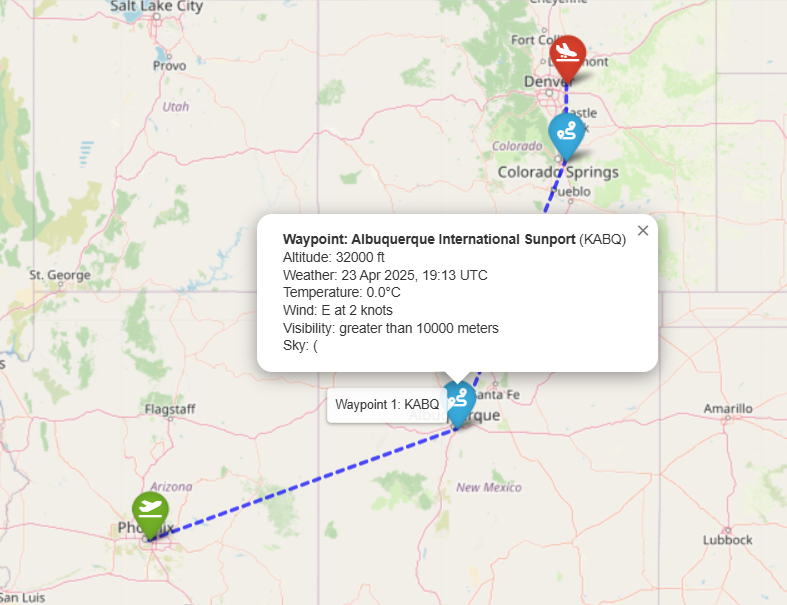

fig 1. Example Output

In [ ]:
def load_airport_data(csv_file):
    """Load airport data from CSV file."""
    try:
        df = pd.read_csv(csv_file)

        airports = {row['icao']: row for _, row in df.iterrows()}
        return airports
    except Exception as e:
        print(f"Error loading airport data: {e}")
        return {}




import requests
from metar.Metar import Metar
from datetime import datetime

def metarsparser(icao, altitude):
    """
    Returns weather data for a given ICAO code and altitude.

    Parameters:
        icao (str): ICAO code of the airport/station
        altitude (int or float): Altitude (currently unused, placeholder for future)

    Returns:
        dict: Parsed weather data from METAR report or error info
    """

    metar_url = "https://aviationweather.gov/api/data/metar"
    params = {
        "format": "json",
        "stationString": icao,
        "hoursBeforeNow": 2
    }

    try:
        response = requests.get(metar_url, params=params)
        response.raise_for_status()
        data = response.json()

        if not data:
            return {"error": "No METAR data available for the specified ICAO code."}


        raw_metar = data[0].get("rawOb", "")
        if not raw_metar:
            return {"error": "No raw METAR observation found."}


        metar = Metar(raw_metar)
        return {
            "station": metar.station_id,
            "time": metar.time.strftime("%d %b %Y, %H:%M UTC") if metar.time else None,
            "wind": str(metar.wind()),
            "visibility": str(metar.visibility()),
            "sky_condition": ', '.join([str(layer) for layer in metar.sky]),
            "temperature": float(metar.temp.value()) if metar.temp else None,
            "dewpoint": float(metar.dewpt.value()) if metar.dewpt else None,
            "altimeter": float(metar.press.value()) if metar.press else None,
            "remarks": metar.remarks
        }

    except requests.exceptions.RequestException as e:
        return {"error": f"HTTP error: {str(e)}"}
    except Exception as e:
        return {"error": f"Parsing error: {str(e)}"}





def create_flight_path_map(origin_icao, origin_alt, waypoints, destination_icao, dest_alt, airport_data):
    """
    Create a flight path map with the given parameters.

    Parameters:
    - origin_icao: ICAO code for departure airport
    - origin_alt: Altitude at departure (in feet)
    - waypoints: List of tuples [(waypoint_icao, altitude), ...]
    - destination_icao: ICAO code for arrival airport
    - dest_alt: Altitude at destination (in feet)
    - airport_data: Dictionary of airport data keyed by ICAO code

    Returns:
    - Folium map object
    """

    if origin_icao not in airport_data:
        raise ValueError(f"Origin airport {origin_icao} not found in airport data")
    if destination_icao not in airport_data:
        raise ValueError(f"Destination airport {destination_icao} not found in airport data")


    origin = airport_data[origin_icao]
    destination = airport_data[destination_icao]


    center_lat = (origin['latitude'] + destination['latitude']) / 2
    center_lon = (origin['longitude'] + destination['longitude']) / 2


    flight_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)


    origin_weather = metarsparser(origin_icao, origin_alt)
    origin_popup = f"""
    <b>{origin['airport']}</b> ({origin_icao})<br>
    Altitude: {origin_alt} ft<br>
    Weather: {origin_weather['time']}<br>
    Temperature: {origin_weather['temperature']}°C<br>
    Wind: {origin_weather['wind']}<br>
    Visibility: {origin_weather['visibility']}<br>
    Sky: {origin_weather['sky_condition'][0]}
    """
    folium.Marker(
        [origin['latitude'], origin['longitude']],
        popup=folium.Popup(origin_popup, max_width=300),
        tooltip=f"{origin_icao} - {origin['airport']}",
        icon=folium.Icon(color='green', icon='plane-departure', prefix='fa')
    ).add_to(flight_map)


    dest_weather = metarsparser(destination_icao, dest_alt)
    dest_popup = f"""
    <b>{destination['airport']}</b> ({destination_icao})<br>
    Altitude: {dest_alt} ft<br>
    Weather: {dest_weather['time']}<br>
    Temperature: {dest_weather['temperature']}°C<br>
    Wind: {dest_weather['wind']}<br>
    Visibility: {dest_weather['visibility']}<br>
    Sky: {dest_weather['sky_condition'][0]}
    """
    folium.Marker(
        [destination['latitude'], destination['longitude']],
        popup=folium.Popup(dest_popup, max_width=300),
        tooltip=f"{destination_icao} - {destination['airport']}",
        icon=folium.Icon(color='red', icon='plane-arrival', prefix='fa')
    ).add_to(flight_map)


    path_coords = [(origin['latitude'], origin['longitude'])]


    for waypoint_idx, (waypoint_icao, waypoint_alt) in enumerate(waypoints):
        if waypoint_icao in airport_data:
            waypoint = airport_data[waypoint_icao]
            waypoint_weather = metarsparser(waypoint_icao, waypoint_alt)
            waypoint_popup = f"""
            <b>Waypoint: {waypoint['airport']}</b> ({waypoint_icao})<br>
            Altitude: {waypoint_alt} ft<br>
            Weather: {waypoint_weather['time']}<br>
            Temperature: {waypoint_weather['temperature']}°C<br>
            Wind: {waypoint_weather['wind']}<br>
            Visibility: {waypoint_weather['visibility']}<br>
            Sky: {waypoint_weather['sky_condition'][0]}
            """
            folium.Marker(
                [waypoint['latitude'], waypoint['longitude']],
                popup=folium.Popup(waypoint_popup, max_width=300),
                tooltip=f"Waypoint {waypoint_idx+1}: {waypoint_icao}",
                icon=folium.Icon(color='blue', icon='route', prefix='fa')
            ).add_to(flight_map)
            path_coords.append((waypoint['latitude'], waypoint['longitude']))
        else:
            print(f"Warning: Waypoint {waypoint_icao} not found in airport data")


    path_coords.append((destination['latitude'], destination['longitude']))


    folium.PolyLine(
        path_coords,
        weight=3,
        color='blue',
        opacity=0.7,
        dash_array='5, 5',
        tooltip='Flight Path'
    ).add_to(flight_map)


    total_distance = 0
    for i in range(len(path_coords) - 1):
        point1 = path_coords[i]
        point2 = path_coords[i + 1]
        total_distance += geodesic(point1, point2).nautical


    flight_info_html = f"""
    <div style="padding: 10px; background-color: white; opacity: 0.8; border-radius: 10px;">
    <h3>Flight Information</h3>
    <b>Origin:</b> {origin['airport']} ({origin_icao})<br>
    <b>Destination:</b> {destination['airport']} ({destination_icao})<br>
    <b>Total Distance:</b> {round(total_distance, 1)} nautical miles<br>
    <b>Waypoints:</b> {len(waypoints)}<br>
    </div>
    """

    flight_map.get_root().html.add_child(folium.Element(flight_info_html))

    return flight_map

def generate_flight_map(origin_icao, origin_alt, waypoints_with_alt, destination_icao, dest_alt, airport_csv_file="airports.csv"):
    """
    Main function to generate a flight path map.

    Parameters:
    - origin_icao: ICAO code for departure airport
    - origin_alt: Altitude at departure (in feet)
    - waypoints_with_alt: List of tuples [(waypoint_icao, altitude), ...]
    - destination_icao: ICAO code for arrival airport
    - dest_alt: Altitude at destination (in feet)
    - airport_csv_file: Path to CSV file with airport data

    Returns:
    - Saves an HTML file with the flight map and returns the map object
    """
    airport_data = load_airport_data(airport_csv_file)

    if not airport_data:
        print("Failed to load airport data.")
        return None

    try:
        flight_map = create_flight_path_map(
            origin_icao,
            origin_alt,
            waypoints_with_alt,
            destination_icao,
            dest_alt,
            airport_data
        )


        output_file = f"flight_path_{origin_icao}_to_{destination_icao}.html"
        flight_map.save(output_file)
        print(f"Flight map saved to {output_file}")

        return flight_map

    except Exception as e:
        print(f"Error generating flight map: {e}")
        return None


if __name__ == "__main__":

    origin = "KPHX"
    origin_altitude = 1135


    waypoints = [
        ("KABQ", 32000),
        ("KCOS", 28000),
    ]

    destination = "KDEN"
    destination_altitude = 5433


    airport_csv = r"/content/iata-icao.csv"


    flight_map = generate_flight_map(
        origin,
        origin_altitude,
        waypoints,
        destination,
        destination_altitude,
        airport_csv
    )

Error loading airport data: [Errno 2] No such file or directory: '/content/iata-icao.csv'
Failed to load airport data.


# Report Generation


In [ ]:


def parse_aviation_weather_data(file_path):

    try:
        with open(file_path, 'r') as file:
            content = file.read()
    except Exception as e:
        return f"Error reading file: {e}"


    region_match = re.search(r'Region: ([A-Z0-9]+)', content)
    region = region_match.group(1) if region_match else "Unknown"


    pirep_section = re.search(r'===== PIREP DATA.*?================', content, re.DOTALL)
    airsigmet_section = re.search(r'===== AIRSIGMET DATA.*?================', content, re.DOTALL)
    metar_section = re.search(r'===== METAR DATA.*?================', content, re.DOTALL)
    taf_section = re.search(r'===== TAF DATA.*?(?:================|Data retrieval complete)', content, re.DOTALL)


    pireps = parse_pireps(pirep_section.group(0) if pirep_section else "")
    airsigmets = parse_airsigmets(airsigmet_section.group(0) if airsigmet_section else "")
    metars = parse_metars(metar_section.group(0) if metar_section else "")
    tafs = parse_tafs(taf_section.group(0) if taf_section else "")

    return {
        "region": region,
        "pireps": pireps,
        "airsigmets": airsigmets,
        "metars": metars,
        "tafs": tafs,
        "generation_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

def parse_pireps(section):
    reports = []
    if not section:
        return reports

    for report_block in re.finditer(r'Report #\d+:\s*(.*?)(?:----+|$)', section, re.DOTALL):
        report_text = report_block.group(1).strip()
        if report_text:

            parsed = {}


            arp_match = re.search(r'ARP\s+(\w+)', report_text)
            parsed['flight_id'] = arp_match.group(1) if arp_match else "Unknown"


            pos_match = re.search(r'(\d+[NS]\d+[EW])', report_text)
            parsed['position'] = pos_match.group(1) if pos_match else "Unknown"


            alt_match = re.search(r'F(\d+)', report_text)
            parsed['altitude'] = f"FL{alt_match.group(1)}" if alt_match else "Unknown"


            temp_match = re.search(r'MS(\d+)', report_text)
            parsed['temperature'] = f"-{temp_match.group(1)}°C" if temp_match else "Unknown"


            wind_match = re.search(r'(\d+)/(\d+)\s+KT', report_text)
            if wind_match:
                parsed['wind_direction'] = wind_match.group(1)
                parsed['wind_speed'] = f"{wind_match.group(2)} knots"
            else:
                parsed['wind'] = "Unknown"

            reports.append({
                'raw': report_text,
                'parsed': parsed
            })

    return reports

def parse_airsigmets(section):
    reports = []
    if not section:
        return reports

    for report_block in re.finditer(r'AIRSIGMET #\d+:.*?Raw text:\s*(.*?)(?:----+|$)', section, re.DOTALL):
        raw_text = report_block.group(1).strip()
        if raw_text:

            parsed = {}


            type_match = re.search(r'CONVECTIVE SIGMET\s+(\w+)', raw_text)
            parsed['type'] = type_match.group(0) if type_match else "Unknown"


            valid_match = re.search(r'VALID UNTIL (\d+Z)', raw_text)
            parsed['valid_until'] = valid_match.group(1) if valid_match else "Unknown"


            area_match = re.search(r'([A-Z]{2}.*?)(?:\n|FROM)', raw_text)
            parsed['areas'] = area_match.group(1).strip() if area_match else "Unknown"


            tops_match = re.search(r'TOPS TO (FL\d+)', raw_text)
            parsed['tops'] = tops_match.group(1) if tops_match else "Unknown"

            reports.append({
                'raw': raw_text,
                'parsed': parsed
            })

    return reports

def parse_metars(section):
    reports = []
    if not section:
        return reports

    for report_block in re.finditer(r'METAR #\d+:\s*(.*?)(?:----+|$)', section, re.DOTALL):
        metar_text = report_block.group(1).strip()
        if metar_text:

            parsed = {}


            station_match = re.search(r'^([A-Z0-9]{4})', metar_text)
            parsed['station'] = station_match.group(1) if station_match else "Unknown"


            time_match = re.search(r'(\d{6}Z)', metar_text)
            parsed['time'] = time_match.group(1) if time_match else "Unknown"


            wind_match = re.search(r'(\d{3}|VRB)(\d{2})KT', metar_text)
            if wind_match:
                direction = wind_match.group(1)
                speed = wind_match.group(2)
                if direction == "VRB":
                    parsed['wind'] = f"Variable at {speed} knots"
                else:
                    parsed['wind'] = f"From {direction}° at {speed} knots"
            else:
                parsed['wind'] = "Unknown"


            vis_match = re.search(r'(?:\s|^)(\d+SM|\d+\/\d+SM|CAVOK|9999)', metar_text)
            parsed['visibility'] = vis_match.group(1) if vis_match else "Unknown"


            cloud_pattern = r'(FEW|SCT|BKN|OVC)(\d{3})(CB|TCU)?'
            cloud_matches = re.finditer(cloud_pattern, metar_text)
            clouds = []
            for match in cloud_matches:
                coverage = match.group(1)
                height = int(match.group(2)) * 100
                cloud_type = match.group(3) if match.group(3) else ""
                clouds.append(f"{coverage} at {height} feet{' ' + cloud_type if cloud_type else ''}")
            parsed['clouds'] = clouds if clouds else "Clear"


            temp_match = re.search(r'\s(\d+)/(\d+)\s', metar_text)
            if temp_match:
                parsed['temperature'] = f"{temp_match.group(1)}°C"
                parsed['dewpoint'] = f"{temp_match.group(2)}°C"
            else:
                parsed['temperature'] = "Unknown"
                parsed['dewpoint'] = "Unknown"


            alt_match = re.search(r'(A\d{4}|Q\d{4})', metar_text)
            if alt_match:
                alt = alt_match.group(1)
                if alt.startswith('A'):
                    parsed['altimeter'] = f"{alt[1:3]}.{alt[3:]} inHg"
                else:
                    parsed['altimeter'] = f"{alt[1:]} hPa"
            else:
                parsed['altimeter'] = "Unknown"

            reports.append({
                'raw': metar_text,
                'parsed': parsed
            })

    return reports

def parse_tafs(section):
    reports = []
    if not section:
        return reports

    for report_block in re.finditer(r'TAF #\d+ - Station: ([A-Z0-9]+).*?Forecast:\s*(.*?)(?:----+|$)', section, re.DOTALL):
        station = report_block.group(1)
        taf_text = report_block.group(2).strip()

        if taf_text:

            sections = []
            main_parts = re.split(r'(FM\d{6})', taf_text)


            if main_parts[0]:
                initial_match = re.search(r'([A-Z0-9]{4})\s+(\d{6}Z)\s+(\d{4}/\d{4})\s+(.*?)(?:FM|$)', main_parts[0])
                if initial_match:
                    sections.append({
                        'type': 'initial',
                        'valid': initial_match.group(3),
                        'conditions': initial_match.group(4).strip()
                    })


            for i in range(1, len(main_parts), 2):
                if i+1 < len(main_parts):
                    sections.append({
                        'type': 'change',
                        'from': main_parts[i],
                        'conditions': main_parts[i+1].strip()
                    })

            reports.append({
                'station': station,
                'raw': taf_text,
                'sections': sections
            })

    return reports

def generate_weather_report(data):

    region = data['region']
    now = datetime.now().strftime("%Y-%m-%d")

    report = f"""# Aviation Weather Report Analysis - {region}
**Report Date: {now}**

## Executive Summary
This analysis covers aviation weather conditions for {get_airport_name(region)} ({region}), based on PIREP, AIRSIGMET, METAR, and TAF data.
{generate_executive_summary(data)}

"""


    if data['metars']:
        report += "## METAR Analysis\n"
        report += "METARs (Meteorological Aerodrome Reports) provide current weather observations at airports.\n\n"

        for metar in data['metars']:
            station = metar['parsed']['station']
            report += f"### {station} ({get_airport_name(station)})\n"
            report += f"**{metar['raw']}**\n\n"


            report += f"* Observation time: {decode_metar_time(metar['parsed']['time'])}\n"
            report += f"* Wind: {metar['parsed']['wind']}\n"
            report += f"* Visibility: {decode_visibility(metar['parsed']['visibility'])}\n"


            if isinstance(metar['parsed']['clouds'], list):
                report += "* Clouds: " + ", ".join(metar['parsed']['clouds']) + "\n"
            else:
                report += f"* Clouds: {metar['parsed']['clouds']}\n"

            report += f"* Temperature: {metar['parsed']['temperature']} / Dew point: {metar['parsed']['dewpoint']}\n"
            report += f"* Altimeter: {metar['parsed']['altimeter']}\n\n"


            report += f"{generate_metar_significance(metar)}\n\n"


    if data['tafs']:
        report += "## TAF Analysis (Terminal Aerodrome Forecast)\n"
        report += "The TAF for " + region + " indicates expected conditions over the next 24 hours:\n\n"

        for taf in data['tafs']:
            if taf['station'] == region:
                report += f"**{taf['raw']}**\n\n"
                report += "This forecast indicates:\n\n"


                for section in taf['sections']:
                    if section['type'] == 'initial':
                        report += f"* Initial conditions ({section['valid']}): {decode_taf_conditions(section['conditions'])}\n"
                    else:
                        time_desc = decode_fm_time(section['from'])
                        report += f"* {time_desc}: {decode_taf_conditions(section['conditions'])}\n"

                report += "\n**Operational Impact:** " + generate_taf_significance(taf) + "\n\n"


    if data['pireps']:
        report += "## PIREP Analysis\n"
        report += "Pilot Reports (PIREPs) provide actual weather conditions experienced by aircraft:\n\n"

        for i, pirep in enumerate(data['pireps']):
            flight_id = pirep['parsed']['flight_id']
            report += f"### Report #{i+1} ({flight_id})\n"


            for key, value in pirep['parsed'].items():
                if key != 'flight_id' and key != 'raw':

                    formatted_key = key.replace('_', ' ').title()
                    report += f"* {formatted_key}: {value}\n"

            report += "\n"

        report += "**Operational Impact:** " + generate_pirep_significance(data['pireps']) + "\n\n"


    if data['airsigmets']:
        report += "## AIRSIGMET Analysis\n"
        report += "AIRSIGMETs provide information about potentially hazardous weather conditions. The current AIRSIGMETs indicate:\n\n"

        for airsigmet in data['airsigmets']:
            if 'type' in airsigmet['parsed']:
                report += f"### {airsigmet['parsed']['type']}\n"
                for key, value in airsigmet['parsed'].items():
                    if key != 'type' and key != 'raw':

                        formatted_key = key.replace('_', ' ').title()
                        report += f"* {formatted_key}: {value}\n"
                report += "\n"

        report += "**Operational Impact:** " + generate_airsigmet_significance(data['airsigmets'], region) + "\n\n"


    report += "## Overall Assessment\n"
    report += generate_overall_assessment(data) + "\n\n"


    report += """## Glossary of Terms

* **METAR**: Meteorological Aerodrome Report - current weather observation
* **TAF**: Terminal Aerodrome Forecast - forecast for an airport
* **PIREP**: Pilot Report - weather conditions reported by aircraft
* **AIRSIGMET**: Airmen's Significant Meteorological Information - advisory of hazardous weather
* **FL**: Flight Level (e.g., FL340 = 34,000 feet pressure altitude)
* **KT**: Knots (nautical miles per hour)
* **SM**: Statute Miles
* **SCT**: Scattered clouds (3/8 to 4/8 sky coverage)
* **FEW**: Few clouds (1/8 to 2/8 sky coverage)
* **BKN**: Broken clouds (5/8 to 7/8 sky coverage)
* **OVC**: Overcast (8/8 sky coverage)
* **HZ**: Haze
* **MS**: Minus (used for negative temperatures in PIREPs, e.g., MS51 = -51°C)
* **P6SM**: Visibility greater than 6 statute miles
* **VRB**: Variable wind direction
* **TEMPO**: Temporary conditions
* **FM**: From (indicates a time when conditions are expected to change)
"""

    return report

def get_airport_name(icao_code):
    """Get the full name of an airport from its ICAO code"""
    airport_names = {
        "KJFK": "John F. Kennedy International Airport",
        "KLGA": "LaGuardia Airport",
        "KEWR": "Newark Liberty International Airport",
        "PKWA": "Kwajalein Atoll",
        "LWSK": "Skopje International Airport",
        "LWOH": "Ohrid St. Paul the Apostle Airport",
        "LLBG": "Ben Gurion International Airport",
        "LATI": "Tirana International Airport"

    }

    return airport_names.get(icao_code, f"Airport {icao_code}")

def decode_metar_time(time_str):
    """Convert METAR time string to human-readable format"""
    try:
        day = int(time_str[0:2])
        hour = int(time_str[2:4])
        minute = int(time_str[4:6])


        now = datetime.now()


        if day > now.day + 15:
            month = now.month - 1
            if month == 0:
                month = 12
                year = now.year - 1
            else:
                year = now.year
        elif day < now.day - 15:
            month = now.month + 1
            if month == 13:
                month = 1
                year = now.year + 1
            else:
                year = now.year
        else:
            month = now.month
            year = now.year

        date_obj = datetime(year, month, day, hour, minute)
        return date_obj.strftime("%B %d, %Y, at %H:%M UTC")
    except:
        return time_str

def decode_visibility(vis_str):
    """Convert visibility string to human-readable format"""
    if vis_str == "9999":
        return "10 kilometers or more (excellent)"
    elif vis_str == "CAVOK":
        return "Ceiling and Visibility OK (excellent conditions)"
    elif "SM" in vis_str:
        if "P6SM" in vis_str:
            return "Greater than 6 statute miles (excellent)"
        elif "/" in vis_str:
            parts = vis_str.replace("SM", "").split("/")
            if len(parts) == 2:
                return f"{parts[0]}/{parts[1]} statute mile (limited)"
        else:
            return f"{vis_str.replace('SM', '')} statute miles"
    return vis_str

def decode_taf_conditions(conditions):
    """Decode TAF condition string into human-readable description"""
    result = []


    wind_match = re.search(r'(\d{3}|VRB)(\d{2})KT', conditions)
    if wind_match:
        direction = wind_match.group(1)
        speed = wind_match.group(2)
        if direction == "VRB":
            result.append(f"Variable wind at {speed} knots")
        else:
            cardinal = get_cardinal_direction(int(direction))
            result.append(f"{cardinal} wind ({direction}°) at {speed} knots")


    vis_match = re.search(r'(?:\s|^)(P6SM|\d+SM|\d+\/\d+SM|CAVOK)', conditions)
    if vis_match:
        result.append(f"visibility {decode_visibility(vis_match.group(1))}")


    cloud_pattern = r'(FEW|SCT|BKN|OVC)(\d{3})(CB|TCU)?'
    cloud_matches = re.finditer(cloud_pattern, conditions)
    clouds = []
    for match in cloud_matches:
        coverage = match.group(1)
        height = int(match.group(2)) * 100
        cloud_type = match.group(3) if match.group(3) else ""
        clouds.append(f"{coverage_to_words(coverage)} clouds at {height} feet{' ' + cloud_type if cloud_type else ''}")

    if clouds:
        result.append(", ".join(clouds))


    wx_pattern = r'\s([-+]?(?:RA|SN|DZ|GR|GS|PL|FG|BR|HZ|FU|DU|SA|PY|VA)(?:[A-Z]{2})*)\s'
    wx_match = re.search(wx_pattern, conditions)
    if wx_match:
        result.append(f"weather: {decode_weather_phenomena(wx_match.group(1))}")

    return ", ".join(result)

def coverage_to_words(coverage):
    """Convert cloud coverage abbreviation to words"""
    coverages = {
        "FEW": "few",
        "SCT": "scattered",
        "BKN": "broken",
        "OVC": "overcast"
    }
    return coverages.get(coverage, coverage)

def decode_weather_phenomena(wx_code):
    """Decode weather phenomena code"""
    intensity = ""
    if wx_code.startswith("+"):
        intensity = "heavy "
        wx_code = wx_code[1:]
    elif wx_code.startswith("-"):
        intensity = "light "
        wx_code = wx_code[1:]

    phenomena = {
        "RA": "rain",
        "SN": "snow",
        "DZ": "drizzle",
        "GR": "hail",
        "GS": "small hail",
        "PL": "ice pellets",
        "FG": "fog",
        "BR": "mist",
        "HZ": "haze",
        "FU": "smoke",
        "DU": "dust",
        "SA": "sand",
        "PY": "spray",
        "VA": "volcanic ash"
    }


    for code, desc in phenomena.items():
        if wx_code == code:
            return f"{intensity}{desc}"


    result = intensity
    for code, desc in phenomena.items():
        if code in wx_code:
            result += f"{desc}, "

    return result.strip(", ")

def decode_fm_time(fm_str):
    """Convert FM time string to human-readable format"""

    try:
        day = fm_str[2:4]
        hour = fm_str[4:6]
        minute = fm_str[6:8]
        return f"From {day}th at {hour}:{minute}Z"
    except:
        return fm_str

def get_cardinal_direction(degrees):
    """Convert degrees to cardinal direction"""
    directions = ["North", "North-northeast", "Northeast", "East-northeast",
                  "East", "East-southeast", "Southeast", "South-southeast",
                  "South", "South-southwest", "Southwest", "West-southwest",
                  "West", "West-northwest", "Northwest", "North-northwest"]

    index = round(degrees / 22.5) % 16
    return directions[index]

def generate_executive_summary(data):
    """Generate an executive summary based on all available data"""

    summary = "Based on the available data, "


    if data['tafs']:
        for taf in data['tafs']:
            if taf['station'] == data['region']:
                if any("VFR" in section.get('conditions', '') for section in taf['sections']):
                    summary += "VFR conditions are expected. "
                elif any("IFR" in section.get('conditions', '') for section in taf['sections']):
                    summary += "IFR conditions are expected. "
                elif any("MVFR" in section.get('conditions', '') for section in taf['sections']):
                    summary += "MVFR conditions are expected. "
                else:

                    if any("TS" in section.get('conditions', '') for section in taf['sections']):
                        summary += "thunderstorms are expected in the vicinity. "
                    elif any("FG" in section.get('conditions', '') for section in taf['sections']):
                        summary += "periods of fog are expected. "
                    else:
                        summary += "generally favorable conditions are expected. "


    if data['airsigmets']:
        summary += "There are " + str(len(data['airsigmets'])) + " active AIRSIGMETs that could affect operations. "

    return summary

def generate_metar_significance(metar):
    """Generate operational significance from METAR data"""

    significance = "These conditions represent "


    vis = metar['parsed']['visibility']
    if "greater than 6" in vis or "10" in vis or "excellent" in vis:
        significance += "VFR conditions with excellent visibility."
    elif "3" in vis or "4" in vis or "5" in vis:
        significance += "MVFR conditions with moderate visibility."
    elif "mile" in vis and any(str(i) in vis for i in range(1, 3)):
        significance += "IFR conditions with reduced visibility."
    elif "mile" in vis and any(str(i) in vis for i in range(0, 1)):
        significance += "LIFR conditions with very poor visibility."
    else:
        significance += "conditions that should be monitored for changes."

    return significance

def generate_taf_significance(taf):
    """Generate operational significance from TAF data"""

    has_ifr = False
    has_ts = False
    has_wind = False
    has_fog = False

    for section in taf['sections']:
        conditions = section.get('conditions', '')
        if "SM" in conditions and not "P6SM" in conditions:
            has_ifr = True
        if "TS" in conditions:
            has_ts = True
        if re.search(r'\d{3}(\d{2})KT', conditions) and int(re.search(r'\d{3}(\d{2})KT', conditions).group(1)) > 20:
            has_wind = True
        if "FG" in conditions:
            has_fog = True

    if has_ifr and has_ts:
        return "The forecast indicates periods of IFR conditions with thunderstorms, which could significantly impact operations. Flight planning should include alternate airports and extra fuel."
    elif has_ifr:
        return "The forecast includes periods of IFR conditions which may require instrument approaches. Flight planning should consider these conditions."
    elif has_ts:
        return "The forecast includes thunderstorm activity which could require deviations or delays."
    elif has_wind:
        return "Strong winds are forecast which could affect runway selection and potentially cause turbulence."
    elif has_fog:
        return "Periods of fog are expected which could reduce visibility and may require instrument approaches."
    else:
        return "The forecast indicates generally favorable conditions for flight operations, with no significant weather expected to impact operations."

def generate_pirep_significance(pireps):
    """Generate operational significance from PIREP data"""

    count = len(pireps)
    high_altitude = sum(1 for p in pireps if 'altitude' in p['parsed'] and 'FL' in p['parsed']['altitude'] and int(p['parsed']['altitude'].replace('FL', '')) > 300)

    cold_temps = [p for p in pireps if 'temperature' in p['parsed'] and '-' in p['parsed']['temperature']]
    avg_temp = 0
    if cold_temps:
        avg_temp = sum(int(p['parsed']['temperature'].replace('°C', '').replace('-', '')) for p in cold_temps) / len(cold_temps)

    has_turbulence = any('turbulence' in p['parsed'].get('raw', '').lower() for p in pireps)
    has_icing = any('ice' in p['parsed'].get('raw', '').lower() for p in pireps)

    if high_altitude > 0 and avg_temp < -40:
        return f"These reports indicate normal conditions for high-altitude flights, with extremely cold temperatures (averaging around -{abs(avg_temp)}°C) typical for these flight levels. {'Wind speeds are moderate to strong, which could affect flight times and fuel consumption.' if any('wind_speed' in p['parsed'] for p in pireps) else ''}"
    elif has_turbulence and has_icing:
        return "Multiple reports indicate both turbulence and icing conditions, which could significantly impact flight operations and comfort. Aircraft should be prepared for these conditions and may need to request altitude changes."
    elif has_turbulence:
        return "Reports indicate areas of turbulence which could impact passenger comfort and require seat belt use during affected portions of flight."
    elif has_icing:
        return "Icing conditions have been reported which could affect aircraft performance. Anti-icing systems may be required."
    else:
        return "These pilot reports suggest relatively standard conditions without significant hazards reported."

def generate_airsigmet_significance(airsigmets, airport_code):
    """Generate operational significance from AIRSIGMET data"""
    convective_count = sum(1 for a in airsigmets if 'CONVECTIVE' in a['parsed'].get('type', ''))
    max_fl = 0

    for a in airsigmets:
        if 'tops' in a['parsed']:
            tops_value = int(a['parsed']['tops'].replace('FL', ''))
            if tops_value > max_fl:
                max_fl = tops_value

    if convective_count > 0:
        return f"There are {convective_count} convective SIGMETs indicating thunderstorm activity, which could significantly impact flight operations. The highest reported tops are at FL{max_fl}, and flights should plan accordingly to avoid these areas."
    else:
        return "There are no convective SIGMETs, but other hazardous weather conditions are reported. Flights should review the specific AIRSIGMET details and plan accordingly."

def generate_overall_assessment(data):
    """Generate an overall assessment based on all data"""
    assessment = "Overall, the weather conditions for the region indicate "


    if any(data['airsigmets']) or any("IFR" in taf['sections'][0]['conditions'] for taf in data['tafs']):
        assessment += "that caution is advised. There are significant weather conditions that could impact flight operations. "
    else:
        assessment += "generally favorable conditions for flight operations. "

    assessment += "Pilots should review the detailed reports for specific planning considerations."

    return assessment


uploaded = files.upload()


file_path = list(uploaded.keys())[0]


data = parse_aviation_weather_data(file_path)
report = generate_weather_report(data)


print(report)

def save_report_as_markdown(report, file_name="weather_report.md"):
    """
    Save the generated weather report as a Markdown file.

    Args:
        report: The weather report as a string.
        file_name: The name of the file to save the report.
    """
    with open(file_name, 'w') as file:
        file.write(report)
    print(f"Report saved as {file_name}")


uploaded = files.upload()


file_path = list(uploaded.keys())[0]


data = parse_aviation_weather_data(file_path)
report = generate_weather_report(data)


save_report_as_markdown(report)


files.download("weather_report.md")

NameError: name 'files' is not defined